In [343]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras import layers, models

# LOAD DATA

In [344]:
def load_data_from_folder(folder_path):
    features = pd.read_csv(f"{folder_path}/gin_gout_ratio.csv", header=None).values
    labels = pd.read_csv(f"{folder_path}/filtered_test_info.csv", header=None)
    V = labels.iloc[:, 0].values
    C = labels.iloc[:, 1].values
    A = V - C
    y = np.column_stack((A, C))  # [A, C]
    return features, y

In [345]:
X_d1, y_d1 = load_data_from_folder("Data_D1")
X_d2, y_d2 = load_data_from_folder("Data_D2")
X_extra, y_extra = load_data_from_folder("Data_D3")

In [346]:
X_all = np.vstack([X_d1, X_d2, X_extra])
y_all = np.vstack([y_d1, y_d2, y_extra])
A_all = y_all[:, 0]

In [347]:
print("🧩 Unique values of A:", np.unique(y_all[:, 0]))
print("🧩 Unique values of C:", np.unique(y_all[:, 1]))

🧩 Unique values of A: [12.5 25.  37.5 50.  62.5 75.  87.5]
🧩 Unique values of C: [12.5 25.  37.5 50.  62.5 75.  87.5]


# MASKING FOR INTERPOLATION AND EXTRAPOLATION

In [348]:
mask_train = (A_all == 25.0) | (A_all == 50.0) | (A_all == 75.0)
mask_interp = (A_all == 37.5) | (A_all == 62.5)
mask_extra = (A_all == 12.5) | (A_all == 87.5)

In [349]:
X_train, y_train = X_all[mask_train], y_all[mask_train]
X_interp, y_interp = X_all[mask_interp], y_all[mask_interp]
X_extra, y_extra = X_all[mask_extra], y_all[mask_extra]

# SCALING DATA

In [350]:
scaler = MinMaxScaler()
y_train_scaled = scaler.fit_transform(y_train)
y_interp_scaled = scaler.transform(y_interp)
y_extra_scaled = scaler.transform(y_extra)

# BUILD MODELS

In [351]:
def build_simple_nn(input_dim=15):
    model = tf.keras.Sequential([
        layers.Input(shape=(input_dim,)),  # use the argument, not a global variable
        layers.Dense(40, activation='relu'),
        layers.Dense(2, activation='linear')
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model


In [352]:
def build_iterative_nn(input_dim):
    model = models.Sequential([
        layers.Input(shape=(input_dim + 2,)),
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(2, activation='linear')
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

In [353]:
def iterative_predict(model, X, iterations=7, A0=50, C0=100):
    A = np.full((X.shape[0], 1), A0)
    C = np.full((X.shape[0], 1), C0)
    for _ in range(iterations):
        preds = model.predict(np.hstack([X, A, C]), verbose=0)
        A, C = preds[:, 0:1], preds[:, 1:2]
    return np.hstack([A, C])

# TRAIN SIMPLE NN

In [354]:
simple_nn = build_simple_nn(k)
simple_nn.fit(X_train, y_train_scaled, epochs=50, batch_size=32, validation_split=0.2, verbose=0)

# TRAIN ITERATIVE NN

In [355]:
k = X_train.shape[1]
iter_nn = build_iterative_nn(X_train.shape[1])
iter_nn.fit(np.hstack([X_train, np.zeros((X_train.shape[0], 2))]), y_train_scaled, epochs=50, batch_size=32, validation_split=0.2, verbose=0)

# PREDICTIONS: INTERPOLATION

In [356]:
pred_interp_simple = scaler.inverse_transform(simple_nn.predict(X_interp))
pred_interp_iter = scaler.inverse_transform(iterative_predict(iter_nn, X_interp))
y_interp_actual = y_interp

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


# PREDICTIONS: EXTRAPOLATION

In [357]:
pred_extra_simple = scaler.inverse_transform(simple_nn.predict(X_extra))
pred_extra_iter = scaler.inverse_transform(iterative_predict(iter_nn, X_extra))
y_extra_actual = y_extra

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 672us/step


# PRINTING METRICS

In [358]:
def print_metrics(name, y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    print(f"🔍 {name}:")
    print(f"  MSE: {mse:.4f}")
    print(f"  MAE: {mae:.4f}\n")

In [359]:
print("📈 Interpolation Results (A = 25 Mbps):")
print_metrics("Simple NN", y_interp_actual, pred_interp_simple)
print_metrics("Iterative NN", y_interp_actual, pred_interp_iter)

📈 Interpolation Results (A = 25 Mbps):
🔍 Simple NN:
  MSE: 306.6496
  MAE: 14.2479

🔍 Iterative NN:
  MSE: 532.9537
  MAE: 19.0575



In [360]:
print("📈 Extrapolation Results (A = 50, 75 Mbps):")
print_metrics("Simple NN", y_extra_actual, pred_extra_simple)
print_metrics("Iterative NN", y_extra_actual, pred_extra_iter)

📈 Extrapolation Results (A = 50, 75 Mbps):
🔍 Simple NN:
  MSE: 486.8075
  MAE: 17.4561

🔍 Iterative NN:
  MSE: 527.0161
  MAE: 17.2264



# PLOTTING GRAPHS

In [361]:
def plot_grouped_A_predictions(A_true, A_simple, A_iterative, title="Grouped A Predictions"):
    unique_A = np.sort(np.unique(A_true))
    plt.figure(figsize=(8, 5))

    for label, pred_A in {
        "Simple NN": A_simple,
        "Iterative NN": A_iterative
    }.items():
        means, stds = [], []
        for val in unique_A:
            mask = A_true == val
            if np.any(mask):
                means.append(np.mean(pred_A[mask]))
                stds.append(np.std(pred_A[mask]))
            else:
                means.append(np.nan)
                stds.append(np.nan)

        plt.errorbar(
            unique_A, means, yerr=stds,
            fmt='o-', capsize=5, label=label
        )

    # Ideal y = x line
    plt.plot([0, 120], [0, 120], 'k--', label="Ideal (y = x)")

    plt.xlabel("True A [Mbps]")
    plt.ylabel("Predicted A [Mbps]")
    plt.title(title)
    plt.xticks(unique_A)
    plt.yticks(np.arange(0, 121, 10))
    plt.ylim(0, 120)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [362]:
def plot_grouped_C_predictions(C_true, C_simple, C_iterative, title="Grouped C Predictions"):
    unique_C = np.sort(np.unique(C_true))
    plt.figure(figsize=(8, 5))

    for label, pred_C in {
        "Simple NN": C_simple,
        "Iterative NN": C_iterative
    }.items():
        means, stds = [], []
        for val in unique_C:
            mask = C_true == val
            if np.any(mask):
                means.append(np.mean(pred_C[mask]))
                stds.append(np.std(pred_C[mask]))
            else:
                means.append(np.nan)
                stds.append(np.nan)

        plt.errorbar(
            unique_C, means, yerr=stds,
            fmt='o-', capsize=5, label=label
        )

    # Ideal y = x line
    plt.plot([0, 120], [0, 120], 'k--', label="Ideal (y = x)")

    plt.xlabel("True C [Mbps]")
    plt.ylabel("Predicted C [Mbps]")
    plt.title(title)
    plt.xticks(unique_C)
    plt.yticks(np.arange(0, 121, 10))
    plt.ylim(0, 120)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [363]:
# ==== Extract A and C values for interpolation ====
A_true_interp = y_interp_actual[:, 0]
C_true_interp = y_interp_actual[:, 1]
A_simple_interp = pred_interp_simple[:, 0]
C_simple_interp = pred_interp_simple[:, 1]
A_iterative_interp = pred_interp_iter[:, 0]
C_iterative_interp = pred_interp_iter[:, 1]

# ==== Extract A and C values for extrapolation ====
A_true_extra = y_extra_actual[:, 0]
C_true_extra = y_extra_actual[:, 1]
A_simple_extra = pred_extra_simple[:, 0]
C_simple_extra = pred_extra_simple[:, 1]
A_iterative_extra = pred_extra_iter[:, 0]
C_iterative_extra = pred_extra_iter[:, 1]



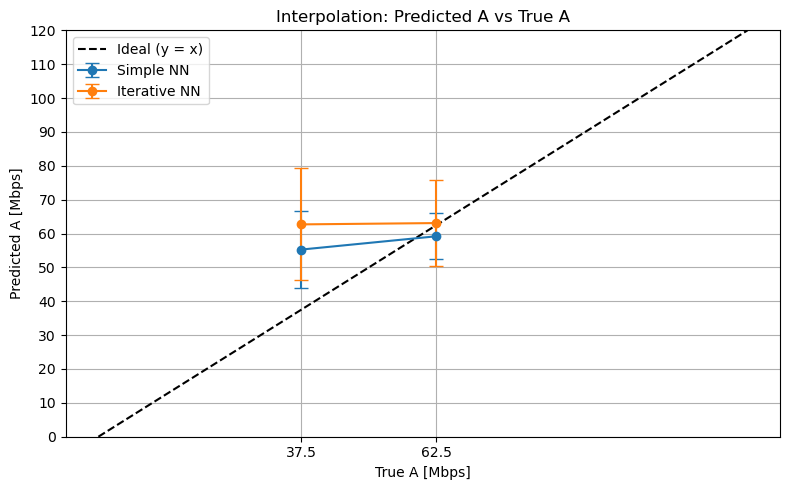

In [364]:
# ==== Plot A: Interpolation ====
plot_grouped_A_predictions(
    A_true_interp, A_simple_interp, A_iterative_interp,
    title="Interpolation: Predicted A vs True A"
)


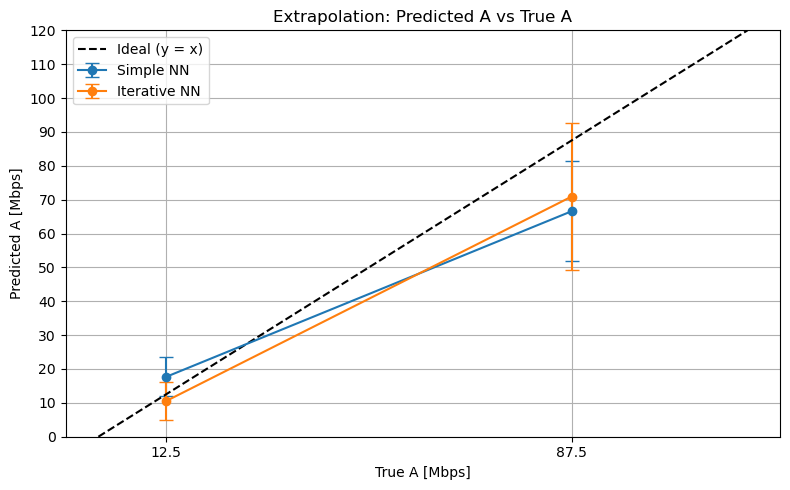

In [365]:
# ==== Plot A: Extrapolation ====
plot_grouped_A_predictions(
    A_true_extra, A_simple_extra, A_iterative_extra,
    title="Extrapolation: Predicted A vs True A"
)


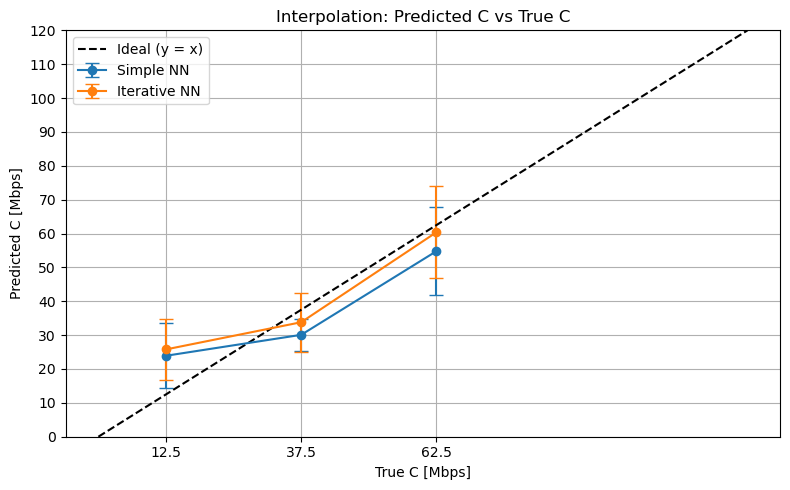

In [366]:
# ==== Plot C: Interpolation ====
plot_grouped_C_predictions(
    C_true_interp, C_simple_interp, C_iterative_interp,
    title="Interpolation: Predicted C vs True C"
)



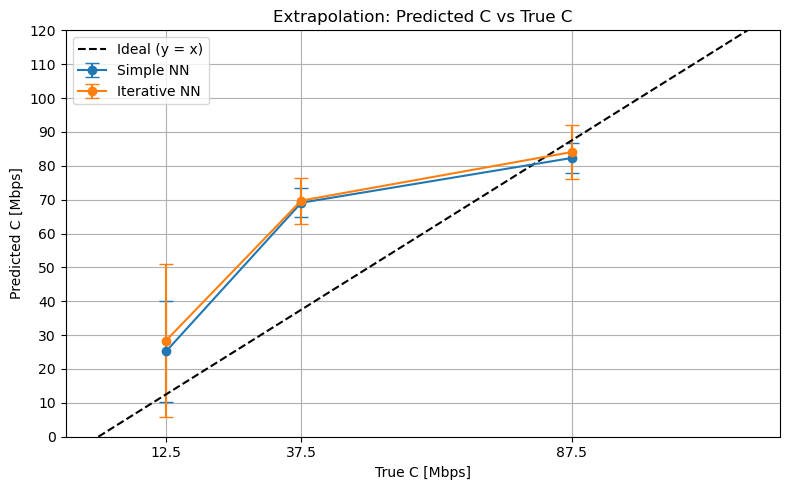

In [367]:
# ==== Plot C: Extrapolation ====
plot_grouped_C_predictions(
    C_true_extra, C_simple_extra, C_iterative_extra,
    title="Extrapolation: Predicted C vs True C"
)
